# Empirical Mode Decomposition

Video [Tutorial](https://www.youtube.com/watch?v=cJXRFZhHcrI)

## Inicio del algoritmo

In [1]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist

from scipy import signal
from scipy import interpolate

## Implementación

Dada una señal $X$, se puede obtener una representación de esta como 

$x(t) = \sum_{k=1}^{K}{a_{k}(t)\Psi_{k}(t)}$

Donde $a_k$ mide la amplitud de modulación y $\Psi_k$ mide las oscilaciones

La idea general del metodo gira alrededor de que las oscilaciones rapidas se superimponen a las oscilaciones lentas

### Implementacion segun Huang et al., 1998

- Identificar los máximos y mínimos locales de la señal
- Deducir una envolvente superior y una envolvente inferior por interpolación (cubic spline)
    - Substraer la envolvente promedio de la señal
    - Iterar hasta que la desviación estandar de la señal sea menor a 0.1
    
        $SD = \sum_{t=0}^{T}{[\frac{|(h_{1(k-1)}(t)-h_{1k}(t))|^2}{h_{1(k-1)}^{2}(t)}]}$

- Substraer la función de modo intrinseco o Intrinsic Mode Function (IMF) de la señal original
- Iterar sobre el residuo

## Caracteristicas del EMD

- **Localidad**: El método opera a la escala de una oscilación
- **Adaptabilidad**: La descomposición es fully data-driven (separation "fast vs slow" data driven)
- **Oscilación arbitraria**: No asume que existe una estructura de armónicos en la oscilación - 1 oscilacion no lineal = 1 modo
- **Multiresolución**: La iteración de exploración procesa secuencialmente la señal en su escala constitutiva natural
- **Evaluación de rendimiento**: La descomposición es definida como la salida del algoritmo (no tiene definición analítica) - necesita de una simulación numérica en situaciones controladas

|  EMD | vs  | DWT  |
|------|-----|------|
|Signal = fast + slow oscillations & iterations   |   | Signal = aproximation + detail & iterations |
|Separation = fast vs slow data driven            |   | Separation = Aprox vs Detail based on a priori dyadic filter|
|Local = Analysis based on extrema                |   | Golbal analysis |
|Has not theoretical framework                    |   | Solid Mathematical Ground|


### Reglas

-	Los extremum (valores máximos y minimos de una funcion) de un IMF y sus cruces por cero deben ser iguales o diferir solo por un punto como máximo en el conjunto de la longitud de la señal
-	El promedio de la envolvente superior definida por los máximos y de la envolvente inferior definida por los minimos debe ser igual a cero


## Método EMD

1. Identificar los picos positivos (máximos) y los picos negativos (mínimos) de la señal original $x(t)$.
2. Construir las envolventes superior e inferior ($e_l(t)$ y $e_u(t)$) a través del método de interpolación de spline cúbico.
3. Calcular el valor promedio promediando ambas envolventes

    $m(t) = \frac{e_u(t)+e_l(t)}{2}$
4. Sustraer el promedio de la señal original para producir la primera señal de detalle

    $d_1(t) = d_0(t)-m(t)
5. Repetir los pasos 1 a 4 hasta que la señal de detalle $d_k(t)$ satisfaga las dos condiciones de IMF mencionadas anteriormente (donde $k$ indica el numero de la iteracion) esto da la primera IMF de $x$

    $c_1(t) = d_k(t)
6. Repetir los pasos 1 a 5 en todos los subsecuentes residuos para obtener todos los IMF

    $r_n(t)=x(t)-c_n(t)$

Ahora, la reconstrucción de la señal se realiza como

$x(t) = \sum_{i=1}^{n}{c_i+r(t)}$

### Implementacion de la funcion EMD

In [2]:
## function to calculate IMF

def emd_2 (x, th = 0.1, process = False):
    # Empirical Mode Decomposition
    # Hilbert-Huang Transform   
    x_o = x.copy()
    imf = []
    while not is_monotonic(x_o):
        x1 = x_o.copy()
        sd = np.infty
        while (sd > th) or (not is_imf(x1)):
            s1 = get_spline(x1)
            s2 = -get_spline(-x1)
            x2 = x1 - (s1 +s2)/2
            sd = np.sum((x1-x2)**2)/np.sum(x1**2)
            x1 = x2.copy()

        if process:
            plt.figure(figsize=(8,4))
            plt.plot(x_o, linewidth = 1)
            plt.plot(s1)
            plt.plot(s2)
            plt.plot(x2, linewidth= 3)

        imf.append(x1)
        x_o = x_o - x1
    
    imf.append(x_o)
    return np.array(imf)
          

def is_imf(x):
    N = len(x)
    u1 = np.sum(np.array(x[0:-2]*x[1:-1] < 0))
    u2 = len(find_peaks(x)) + len(find_peaks(-x))
    if np.abs(u1 - u2) > 1: return False
    else: return True


def is_monotonic(x):
    # Function to verify if the signal is monotonic
    # u1 = len(signal.find_peaks(u))*len(signal.find_peaks(-u))
    u1 = len(find_peaks(x))*len(find_peaks(-x))
    if u1 > 0: return False
    else: return True


def get_spline(x):
    # Function to create spline of the signal
    N = len(x)
    p = find_peaks(x)
    x1 = np.concatenate((np.array([0]), p[:,0], np.array([N])))
    y1 = np.concatenate((np.array([0]), x[p[:,0]], np.array([0])))
    f = interpolate.CubicSpline(x1, y1)
    xnew = np.arange(0, N, 1)
    s = f(xnew)
    return s


def find_peaks(x):
    # Function to find peaks in a signal
    peaks = np.array(np.where(np.diff(np.array(np.diff(x) > 0, dtype='float')) < 0))
    ind = np.where(x[peaks+1] > x[peaks])
    peaks[ind] = peaks[ind] + 1
    return(peaks.T)



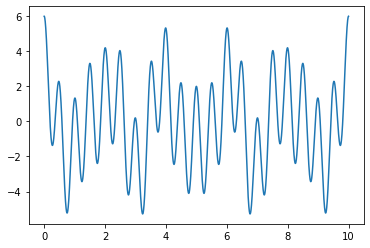

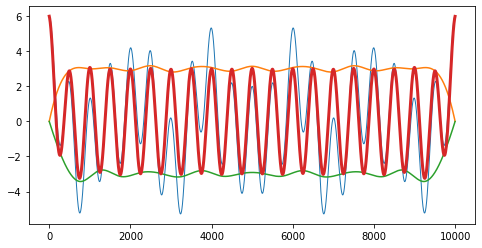

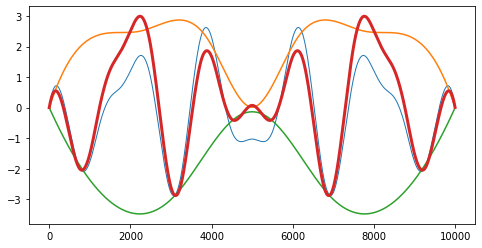

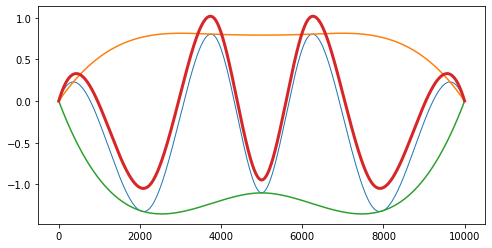

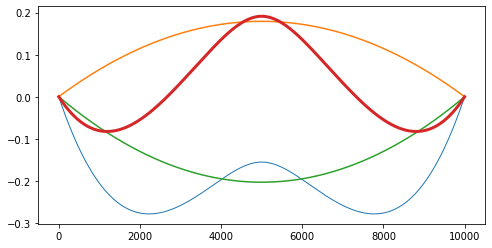

In [3]:
t = np.arange(0, 10, 1/1000)

x = 2*np.cos(np.pi*2*0.5*t) + 1*np.cos(np.pi*2*0.8*t) + 3*np.cos(np.pi*2*2*t)
plt.plot(t, x)

modes = emd_2(x, process = True)
h, w = modes.shape


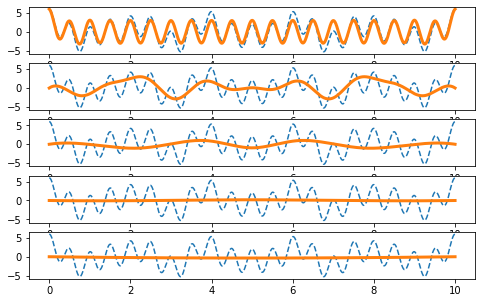

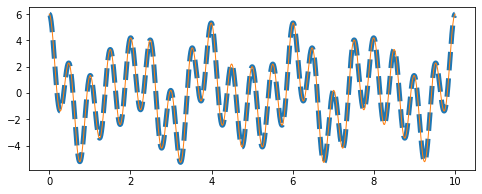

In [4]:
plt.figure(figsize=(8,h))
for i in range(h):
    plt.subplot(h,1,i+1)
    plt.plot(t, x, '--')
    plt.plot(t, modes[i,:], linewidth=3)

rec = np.sum(modes, axis= 0)
plt.figure(figsize=(8,3))
plt.plot(t, x, '--', linewidth=5)
plt.plot(t, rec, linewidth=1)

## Ensembled Empirical Mode Decomposition

Este método entrega los verdaderos IMFs(IMF~) como el promedio de los correspondientes IMF obtenidos del EMD sobre un conjunto de senderos (ensemble of trails), generados por la adicion de diferentes relaizaciones de ruido blanco de varianza finita para la señla original $x[n]$.

1. Generar $x^i[n] = x[n]+w^i[n]$, donde $w^i$ con $i=1,2,...,I$ son las diferentes realizaciones de ruido gaussiano

2. Cada $x^i$ es totalmente descompuesto por el EMD obteniendo los $IMF_k^i[n]$, donde $k$ indica los modos

3. Asignar el $IMF_k$ como el k-esimo modo de la señal $x$, obtenido como el promedio de las correspondientes IMFx asi:

    $IMF_k^i:IMF_k^~[n]=\frac{1}{I}IMF_k^i[n]$ 
    
    y cada uno de los residuos se obtiene como:

    $r_k^i[n]=r_{k-1}^i[n]-IMF_k^i[n]$

    La amplitud del ruido blanco agregado juega un papel fundamental, si la amplitud del ruido agregado es muy pequeño con relación a la señal original no tendrá efecto en la prevención del mode mixing, y si es muy grande, puede resultar en componentes IMF redundantes. Se recomienda que la amplitudo del ruido sea de $0.2$ veces la desviacion estándar de la señal original.

## Implementación



In [5]:
def eemd_2(x, re = 10, sdp = 0.2):
    # Implementacion de eemd con 10 realizaciones

    imf = []  # arreglo para los imf
    shapes = []
    mu, sigma = 0, np.std(x)
    for i in range(re):
        x_i = x.copy()
        x_i_w = x_i + np.random.normal(mu, sdp*sigma, len(x_i))

        imf_i = emd_2(x_i_w)
        shapes.append(imf_i.shape[0])

        imf.append(imf_i)

    length = max(shapes)

    for i in range (re):
        for j in range (shapes[i],length):
            #print(imf[i][j].shape)
            imf[i] = np.append(imf[i], [np.zeros(x.shape)], axis=0)

    return np.array(imf)


In [6]:
re = 15
sdp = 0.5

modes_e = eemd_2(x, re = re, sdp = sdp)


In [7]:
imfs = np.sum(modes_e, axis=0)/re

h, w = imfs.shape


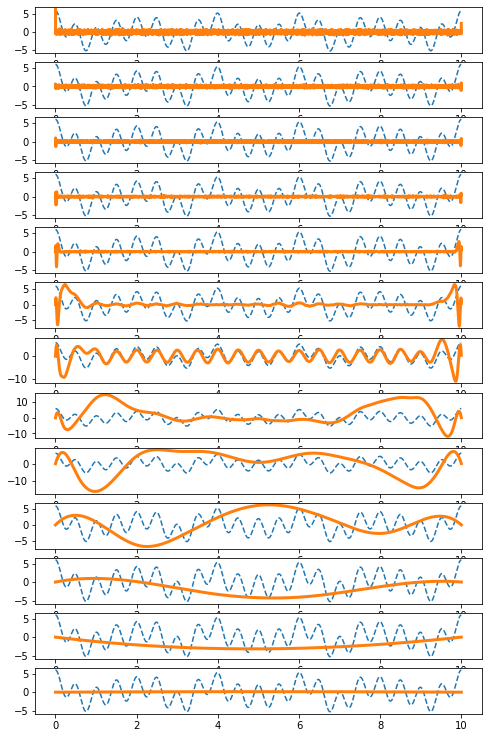

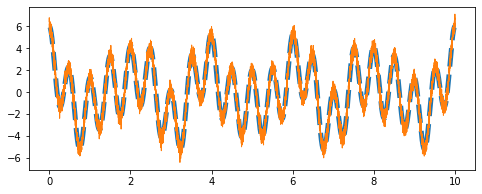

In [8]:
plt.figure(figsize=(8,h))
for i in range(h):
    plt.subplot(h,1,i+1)
    plt.plot(t, x, '--')
    plt.plot(t, imfs[i,:], linewidth=3)

rec = np.sum(imfs, axis= 0)
plt.figure(figsize=(8,3))
plt.plot(t, x, '--', linewidth=5)
plt.plot(t, rec, linewidth=1)